<a href="https://colab.research.google.com/github/rayaneghilene/CNN_Barcode_detection/blob/main/Barcodedetection_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Barcode detection using CNN

In [1]:
#Imports :

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transform
import pandas as pd
from sklearn.model_selection import train_test_split


# 1- Exploring the data

## Dataset
The dataset used for this project is provided by the "Applied Recognition Technology Laboratory Department of Theoretical and Applied Science"

*Neural Image Restoration For Decoding 1-D Barcodes Using Common Camera Phones
Alessandro Zamberletti, Ignazio Gallo, Moreno Carullo and Elisabetta Binaghi
Computer Vision, Imaging and Computer Graphics. Theory and Applications, Springer Berlin Heidelberg, 2011*

The following dataset will be divided into three sets:

- Training set is used to train the Model (i.e., to find the parameters of Model).
- Validation set is used to watch the Model's training (to verify whether the training procedure goes well).
- Test set is used to evaluate the performance of the Model (in our case, to measure if the model compresses and decompresses well new images).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Creation of the Dataset

In [22]:
import os
from PIL import Image

dataset_dir = '/content/drive/MyDrive/Dataset1/Dataset2'
dataset = []
for image_filename in os.listdir(dataset_dir):
    if image_filename.endswith('.jpg'):
        barcode_number = os.path.splitext(image_filename)[0]
        image_path = os.path.join(dataset_dir, image_filename)
        text_file_path = os.path.join(dataset_dir, barcode_number +'.jpg' +'.txt')
        image = Image.open(image_path)

        with open(text_file_path, 'r') as file:
            text_data = file.read().strip()  # Assuming the barcode number is the entire contents of the text file

        data_sample = {
            'image': image,
            'barcode_number': text_data
        }

        dataset.append(data_sample)

size_of_dataset =  len(dataset)
print(size_of_dataset)


215


(864, 1152, 3)


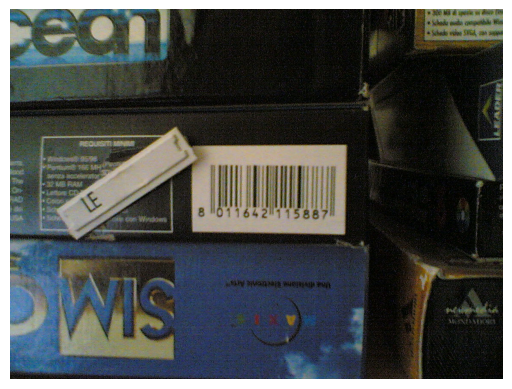

The corresponding barcode number is : 8011642115887


In [32]:
data = dataset[4]
image_array = np.array(data['image'])
print(image_array.shape)



image = data['image']
txt = data['barcode_number']

plt.imshow(image)
plt.axis('off')
plt.show()
print("The corresponding barcode number is :", txt)


###Checking the shape of the images in the dataset

In [33]:
data = dataset[0]
reference_shape = np.array(data['image']).shape

all_same_shape = True

for data in dataset[1:]:
    image_shape = np.array(data['image']).shape

    if image_shape != reference_shape:
        all_same_shape = False
        break

if all_same_shape:
    print("All images have the same shape:", reference_shape)
else:
    print("Images have different shapes.")


All images have the same shape: (864, 1152, 3)


###Spliting the data into three sets :Training, Testing and Validation

In [34]:
# Split dataset into training and remaining data
train_data, remaining_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Split remaining data into testing and validation sets
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

# Print the sizes of each set
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))
print("Validation set size:", len(val_data))


Train set size: 172
Test set size: 21
Validation set size: 22


#2 - Creating and training the model

##Model Architecture

In [35]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        input_channels = 3

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(size=(864, 1152), mode='bilinear', align_corners=False)  # Upsample to the desired output size
        )

    def forward(self, x):
        return self.model(x)
    def recognize_barcode(self, image):
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        input_tensor = preprocess(image).unsqueeze(0)

        self.eval()
        with torch.no_grad():
            output_tensor = self.forward(input_tensor)

        # Reshape the output tensor
        output_tensor = output_tensor.squeeze().permute(1, 2, 0)  # Shape: (139, 186, 3)

        # Find the maximum value along the channel dimension
        predicted_number = output_tensor.argmax().item()

        return predicted_number


# Initialize the model
model = CustomModel()
print(model)


CustomModel(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

##Training

###i - Loss function
The loss function must tell us how far our predictions are from the true labels. This could be done by comparing the distributions of two input data, or by directly comparing the data using some distance metrics.

In [36]:
criterion = nn.MSELoss()

###ii - An Optimizer
We need gradually update the weights of the model. In fact, we perform the gradient descent to recalculate the weights of each layer regarding the model's predictions. The optimizer will search for an Optimum. It needs a step to perform this research. This step is called the learning rate. The learning rate has an important effect on the learning phase (duration, convergence,...)

In [37]:
learning_rate =  0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###iii - Training

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomModel().to(device)

num_epochs = 10
mini_batches_print = 10
loss_train = []
loss_val = []
loss_test = []
# Training loop
for epoch in range(num_epochs):
    running_loss_t = 0.0

    # Set the model to training mode
    model.train()

    for i, data in enumerate(train_data):
        image, txt = data['image'], data['barcode_number']
        image_np = np.array(image)
        image_tensor = torch.from_numpy(image_np).to(device).float()
        image_tensor = image_tensor.permute(2, 0, 1)
        image_tensor = torch.unsqueeze(image_tensor, dim=0)
        optimizer.zero_grad()
        outputs = model(image_tensor)

        # Resize the target tensor
        target_tensor = image_tensor.clone()
        target_tensor = F.interpolate(target_tensor, size=(outputs.size(2), outputs.size(3)), mode='bilinear', align_corners=False)

        loss = criterion(outputs, target_tensor)
        loss.backward()
        optimizer.step()

        running_loss_t += loss.item()
        # Print mini-batch progress
        #if (i+1) % mini_batches_print == 0:
            #mini_batch_loss = running_loss_t / mini_batches_print
            #print(f'Epoch [{epoch+1}/{num_epochs}], Mini-Batch [{i+1}/{len(train_data)}], Loss: {mini_batch_loss:.4f}')

    # Calculate the average training loss per epoch
    epoch_loss = running_loss_t / len(train_data)
    print('Epoch', epoch+1, 'completed. Training loss:', epoch_loss)
    loss_train.append(epoch_loss)
    running_loss_t = 0.0
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    running_loss_v = 0.0

    with torch.no_grad():
        for data in val_data:
            image, txt = data['image'], data['barcode_number']
            image_np = np.array(image)
            image_tensor = torch.from_numpy(image_np).to(device).float()
            image_tensor = image_tensor.permute(2, 0, 1)
            image_tensor = torch.unsqueeze(image_tensor, dim=0)
            outputs = model(image_tensor)

            # Resize the target tensor
            target_tensor = image_tensor.clone()
            target_tensor = F.interpolate(target_tensor, size=(outputs.size(2), outputs.size(3)), mode='bilinear', align_corners=False)

            loss = criterion(outputs, target_tensor)
            running_loss_v += loss.item()

        epoch_loss_val = running_loss_v / len(val_data)
        print('Epoch', epoch+1, 'completed. Validation loss:', epoch_loss_val)
        loss_val.append(epoch_loss_val)

    # Testing loop
    model.eval()
    running_loss_test = 0.0

    with torch.no_grad():
        for data in test_data:
            image, txt = data['image'], data['barcode_number']
            image_np = np.array(image)
            image_tensor = torch.from_numpy(image_np).to(device).float()
            image_tensor = image_tensor.permute(2, 0, 1)
            image_tensor = torch.unsqueeze(image_tensor, dim=0)
            outputs = model(image_tensor)

            # Resize the target tensor
            target_tensor = image_tensor.clone()
            target_tensor = F.interpolate(target_tensor, size=(outputs.size(2), outputs.size(3)), mode='bilinear', align_corners=False)

            loss = criterion(outputs, target_tensor)
            running_loss_test += loss.item()

        test_loss = running_loss_test / len(test_data)
        print('Testing completed. Test loss:', test_loss)

# Print the final training loss, validation loss, and test loss
print('Training completed. Final training loss:', loss_train[-1])
print('Final validation loss:', loss_val[-1])
print('Final test loss:', test_loss)

Epoch 1 completed. Training loss: 17737.811137354653
Epoch 1 completed. Validation loss: 17713.069113991478
Testing completed. Test loss: 18870.735026041668
Epoch 2 completed. Training loss: 17737.811137354653
Epoch 2 completed. Validation loss: 17713.06902521307
Testing completed. Test loss: 18870.734933035714
Epoch 3 completed. Training loss: 17737.811137354653
Epoch 3 completed. Validation loss: 17713.06902521307
Testing completed. Test loss: 18870.734933035714
Epoch 4 completed. Training loss: 17737.811137354653
Epoch 4 completed. Validation loss: 17713.06902521307
Testing completed. Test loss: 18870.734933035714
Epoch 5 completed. Training loss: 17737.811137354653
Epoch 5 completed. Validation loss: 17713.06902521307
Testing completed. Test loss: 18870.734933035714
Epoch 6 completed. Training loss: 17737.811137354653
Epoch 6 completed. Validation loss: 17713.06902521307
Testing completed. Test loss: 18870.734933035714
Epoch 7 completed. Training loss: 17737.811137354653
Epoch 7 co

loss plot

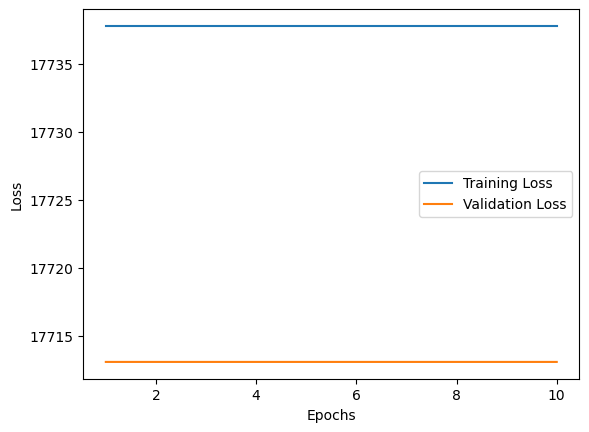

In [39]:
# Plot the losses
plt.plot(range(1, num_epochs+1), loss_train, label='Training Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Validation Loss')
#plt.plot(range(1, num_epochs+1), loss_test, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

I was only able to run one epoch that's whywe can't visualize the loss plot

###iiii - Test on a random barcode

In [42]:
# Create an instance of the CustomModel class
model = CustomModel()

# Load the input image
image = Image.open('barcode.jpg')

# Call the recognize_barcode method
predicted_barcode = model.recognize_barcode(image)

# Print the predicted barcode number
print('Predicted Barcode:', predicted_barcode)


Predicted Barcode: 2933309


#Conclusion
The predicted Barcode is very inaccurate due to the low number of training images and the very modest epoch_num, this was just a test to make sure the model will be able to predict barcode numbers,
a test of 10 epochs recquired 3hours for 86 images which means in order to get a well performing model it is mandatory to run the code on powerfull machines and to perform data augmentation techniques on the dataset.